In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import datetime
import pyodbc
%matplotlib inline

In [2]:
conn = pyodbc.connect('DRIVER={SQL Server};SERVER=10.0.185.138;DATABASE=JYDB;UID=js_dev;PWD=js_dev')

In [3]:
end_date = datetime.datetime.today() - datetime.timedelta(1)
start_date = end_date - datetime.timedelta(60)

# 获取行业分类表并根据流动市值计算中信二级行业权重

In [4]:
theme = pd.read_excel(u'../data/行业分类表.xlsx', sheet_name=u'中信二级行业')

In [5]:
mv = pd.read_excel(u'../data/行业分类表.xlsx', sheet_name=u'行业市值')

In [6]:
mv[u'代码'] = [x.rstrip('.WI') for x in mv[u'代码']]

In [7]:
mv[u'行业名称'] = [x.rstrip(u'\(中信\)').rstrip(u'Ⅱ') for x in mv[u'名称']]

In [8]:
mv = mv.set_index(u'行业名称')

In [9]:
columns = [u'金融地产', u'可选消费', u'必选医药', u'信息科技']
weights = {}
theme_codes = []
for col in columns:
    print(col)
    sectors = theme[col].dropna().tolist()
    codes, weight = [], []
    for s in sectors:
        theme_codes.append(mv.loc[s][u'代码'])
        codes.append(mv.loc[s][u'代码'])
        weight.append(mv.loc[s][u'总市值（亿元）'])
    weight = pd.Series(weight, index=codes)
    weight /= weight.sum()
    weights[col] = weight

金融地产
可选消费
必选医药
信息科技


# 获取股票指数历史收益率

### 获取中信二级行业历史收盘价

In [15]:
codes = ['\'%s\''%(x) for x in theme_codes]
set_codes = '(' + ','.join(codes) + ')'

In [16]:
query = 'select t.SecuCode, t.SecuAbbr, q.TradingDay, q.ClosePrice \
         from SecuMain as t, QT_IndexQuote as q \
         where q.InnerCode = t.InnerCode \
             and t.SecuCode in %s \
             and q.TradingDay >= \'%s\' \
         order by q.TradingDay'%(set_codes, start_date.strftime('%Y-%m-%d'))

In [18]:
df = pd.read_sql_query(query, con=conn)

In [20]:
df = df.set_index('TradingDay')

In [21]:
ret = pd.DataFrame(columns=df['SecuCode'].unique())
for col in ret.columns:
    ret[col] = df[df['SecuCode'] == col]['ClosePrice'].pct_change()

# 计算主题行业按市值加权历史收益率

In [22]:
rdf = pd.DataFrame(columns=columns)
for col in columns:
    print(col)
    rdf[col] = ret[weights[col].index].dropna().mul(weights[col], axis=1).sum(axis=1)

金融地产
可选消费
必选医药
信息科技


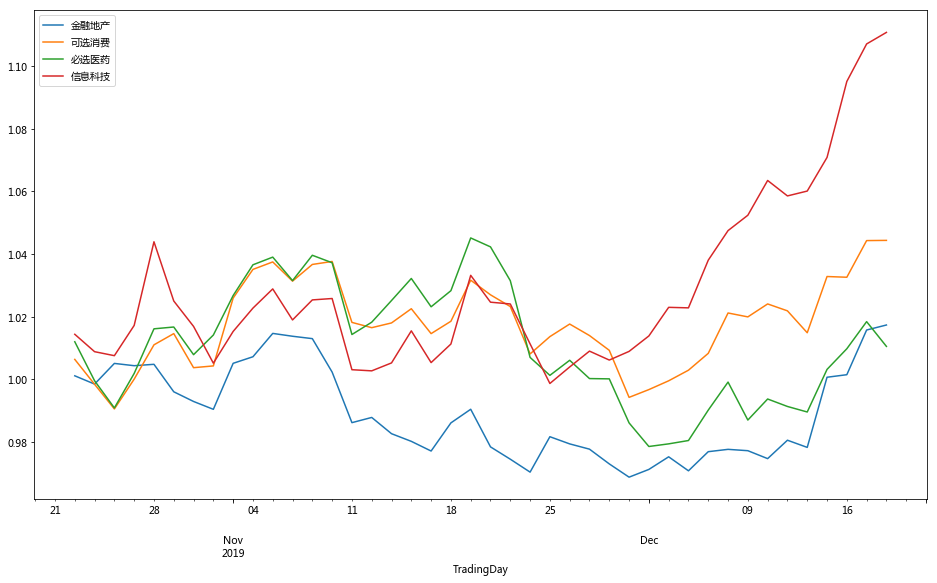

In [23]:
(1 + rdf).cumprod().plot(figsize=(16, 9))

# 获取股票基金历史收益率

In [116]:
fund_df = pd.read_excel(u'../data/股票基金池.xlsx')
# fund_df = pd.read_excel(u'../data/嘉实股票基金池.xlsx')

In [117]:
fund_df

,代码,名称,市值占净值
0,160716.OF,嘉实基本面50指数(LOF)A,0.042779
1,110022.OF,易方达消费行业,0.037537
2,001717.OF,工银瑞信前沿医疗,0.035412
3,001071.OF,华安媒体互联网,0.031038
4,519069.OF,汇添富价值精选A,0.026496
5,163407.OF,兴全沪深300指数增强A,0.024772
6,519736.OF,交银新成长,0.016176
7,001938.OF,中欧时代先锋A,0.015608


In [118]:
codes = fund_df[u'代码'].tolist()

In [119]:
set_codes = '(' + ','.join(['\'%s\''%(x.rstrip('.OF')) for x in codes]) + ')'

In [120]:
query = 'select t.SecuCode, t.SecuAbbr, nv.EndDate, nv.AccumulatedUnitNV \
         from MF_NetValue as nv, SecuMain as t \
             where nv.InnerCode = t.InnerCode \
             and t.SecuCode in %s \
             and nv.InfoPublDate >= \'%s\' \
             order by t.SecuCode, nv.EndDate'%(set_codes, start_date.strftime('%Y-%m-%d'))

In [121]:
fund = pd.read_sql_query(query, con=conn)

In [122]:
fund = fund.set_index('EndDate')

In [123]:
fdf = pd.DataFrame(columns=codes)
for col in fdf.columns:
#     print(col)
    fdf[col] = fund[fund['SecuCode'] == col.rstrip('.OF')]['AccumulatedUnitNV']

In [124]:
rfdf = fdf.pct_change().dropna()

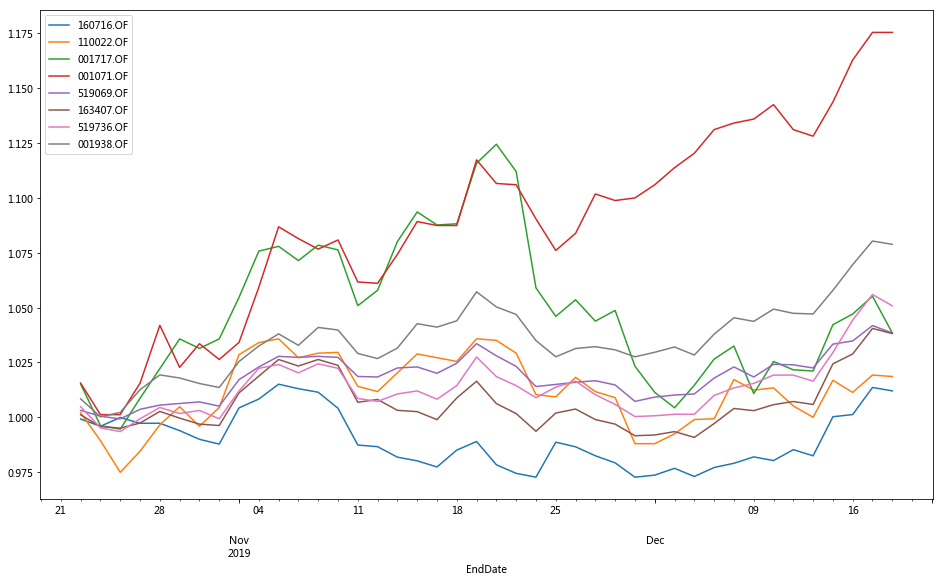

In [125]:
(1 + rfdf).cumprod().plot(figsize=(16, 9))

In [126]:
codes = rfdf.columns.tolist()

In [127]:
print(rfdf.shape)
print(rdf.shape)

(42, 8)
(42, 4)


# 非负线性优化求解

In [128]:
# decomp = pd.DataFrame(index=codes, columns=[u'金融地产', u'消费', u'医药', u'科技'])
decomp = pd.DataFrame(index=codes, columns=[u'金融地产', u'可选消费', u'必选医药', u'信息科技'])
decomp.index.name = u'基金代码'

In [129]:
def objective(coef, args):
    n = coef.size
    X, y = args[0], args[1]
    target = np.dot(X, coef)
#     error = np.sum(np.square(target - y))
    error = np.sum(np.square(target - y)) + np.linalg.norm(coef, 1) # lasso error
    return error / n

def decomposition(code):
    TOLERANCE = 1e-10
    n = rdf.shape[1]
    init_weights = np.array([1. / n] * n)
    X = rdf.values
    y = rfdf[code].values
    
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1.0},
                   {'type': 'ineq', 'fun': lambda x: x})
    
    opt_res = minimize(fun=objective,
                       x0=init_weights,
                       args=[X, y],
                       constraints=constraints,
                       tol=TOLERANCE,
                       options={'disp': True})
    
    return opt_res.x

In [130]:
decomposition(codes[0])

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.2500380375558455
            Iterations: 16
            Function evaluations: 96
            Gradient evaluations: 16


array([ 8.85330463e-01,  1.14669537e-01, -1.51517254e-17, -1.25022063e-17])

In [131]:
for c in codes:
    weight = decomposition(c)
    decomp.loc[c] = weight

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.2500380375558455
            Iterations: 16
            Function evaluations: 96
            Gradient evaluations: 16
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.25016496825007656
            Iterations: 18
            Function evaluations: 108
            Gradient evaluations: 18
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.25052389479334713
            Iterations: 17
            Function evaluations: 102
            Gradient evaluations: 17
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.25048654510962987
            Iterations: 17
            Function evaluations: 102
            Gradient evaluations: 17
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.2501279782803791
            Iterations: 14
            F

In [132]:
decomp[u'基金名称'] = fund_df[fund_df[u'代码'].isin(codes)][u'名称'].tolist()

In [133]:
if u'市值占净值' in fund_df.columns:
    decomp[u'市值占净值'] = fund_df[fund_df[u'代码'].isin(codes)][u'市值占净值'].tolist()

In [134]:
decomp = decomp[decomp.columns[4:].tolist() + decomp.columns[:4].tolist()]

In [135]:
decomp

,基金名称,市值占净值,金融地产,可选消费,必选医药,信息科技
基金代码,,,,,,
160716.OF,嘉实基本面50指数(LOF)A,0.042779,0.88533,0.11467,-1.51517e-17,-1.25022e-17
110022.OF,易方达消费行业,0.037537,-4.12742e-17,0.842988,0.157012,3.17558e-17
001717.OF,工银瑞信前沿医疗,0.035412,2.70949e-17,-2.02963e-16,1,-7.12332e-17
001071.OF,华安媒体互联网,0.031038,-3.65918e-18,-6.32856e-19,0.0920438,0.907956
519069.OF,汇添富价值精选A,0.026496,0.486484,0.222153,0.265234,0.0261296
163407.OF,兴全沪深300指数增强A,0.024772,0.60016,0.252478,0.109596,0.0377652
519736.OF,交银新成长,0.016176,0.44617,0.161966,0.196389,0.195475
001938.OF,中欧时代先锋A,0.015608,0.280772,0.0876585,0.308386,0.323184


In [136]:
if u'市值占净值' in fund_df.columns:
    decomp = decomp.append(pd.DataFrame([['', '',
                           np.dot(decomp[u'金融地产'], fund_df[u'市值占净值']) / fund_df[u'市值占净值'].sum(),
                           np.dot(decomp[u'可选消费'], fund_df[u'市值占净值']) / fund_df[u'市值占净值'].sum(),
                           np.dot(decomp[u'必选医药'], fund_df[u'市值占净值']) / fund_df[u'市值占净值'].sum(),
                           np.dot(decomp[u'信息科技'], fund_df[u'市值占净值']) / fund_df[u'市值占净值'].sum(), 
                           ]], index=[u'组合'], columns=decomp.columns))

In [137]:
decomp.to_excel(u'../data/股票基金收益率分解.xlsx')
# decomp.to_excel(u'../data/嘉实股票基金收益率分解.xlsx')